## Overview
1. Define the mission
2. Explore the data
3. Fine-tune a model
4. Evaluate the result

## What we want to do

```
┌─────────────────────┐ ┌────────────────┐
│                     │ │                │
│  Distillbert Model  │ │  Emotion data  │
│                     │ │                │
└────┬────────────────┘ └────────┬───────┘
     │                           │
     │     ┌───────────────┐     │
     │     │               │     │
     └────►│   Fine-tune   │◄────┘
           │               │
           └───────┬───────┘
                   │
                   ▼
           ┌───────────────┐
           │               │
           │   New Model   │
           │               │
           └───────────────┘
                   │
                   ▼
           ┌───────────────┐
           │               │
           │     Tests     │
           │               │
           └───────────────┘           
```  



In [43]:
from datasets import load_dataset
import pandas as pd
import numpy as np

In [3]:
# Download the dataset from https://huggingface.co/datasets/dair-ai/emotion
emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (F:/huggingface_cache/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

## Explore the data

In [4]:
# Dataset overview
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
# Look at the train subset
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
# pick one record
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
# View the metadata
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [9]:
# Convert to a pandas data frame and view some samples
emotions.set_format(type="pandas")
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
# Resolve the enum text as additional column 'label_name'
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name,Word count per tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


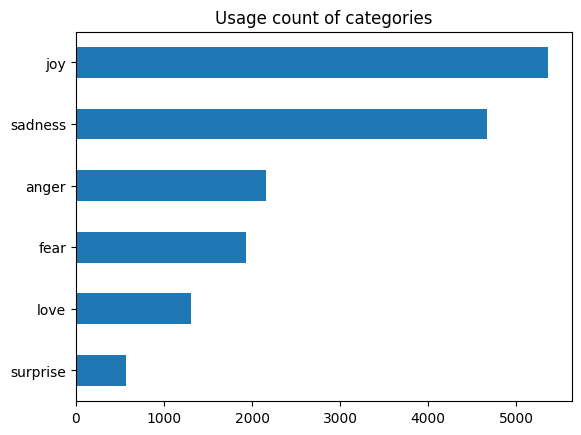

In [14]:
# Bar plot data split per category
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Usage count of categories")
plt.show()

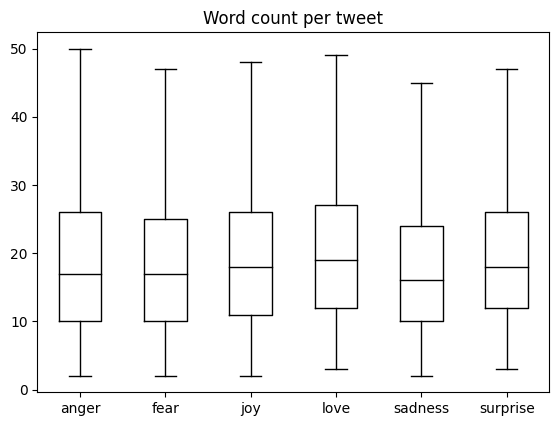

In [17]:
# Plot word count range per tweet
df["word_count_per_tweet"] = df["text"].str.split().apply(len)
df.boxplot("Word count per tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [18]:
# Reset changes on emotions dataset
emotions.reset_format()

## Fine-tune an exisiting distilbert-base-uncased model

In [19]:
# Load the tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [23]:
print(f'Vocab size: {tokenizer.vocab_size}')
print(f'Tokenizer max input size: {tokenizer.model_max_length}')
print(f'Model input names: {tokenizer.model_input_names}')

Vocab size: 30522
Tokenizer max input size: 512
Model input names: ['input_ids', 'attention_mask']


In [24]:
# Function to tokenize the dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)


In [25]:
# Example of one record after tokenization
tokenize(emotions['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [26]:
# Apply tokenization on complete dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [27]:
# Dataset with additional columns 'input_ids' and 'attention_mask'
emotions_encoded['train'].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [28]:
# View the pytorch tensor size
tokenizer("this is a test", return_tensors="pt")['input_ids'].size()

torch.Size([1, 6])

In [29]:
# Load the existing base model, extend to support 6 labels (emotions from our dataset)
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels).to("cuda"))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.

In [31]:
# Function to calculate accurary and f1 score
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1":f1}

In [34]:
# Ensure huggingface login to share the model
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (manager-core).
Your token has been saved to C:\Users\mlach\.cache\huggingface\token
Login successful


In [37]:
# Prepare training arguments
from transformers import TrainingArguments

batch_size=64
logging_steps = len(emotions_encoded['train'])
model_name = f'distilbert-base-uncased-finetuned-emotion'
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    save_strategy="epoch",
    load_best_model_at_end=True,
    log_level="error"
)

In [38]:
# Prepare a model trainer instance
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer
)

Cloning https://huggingface.co/Promotos/distilbert-base-uncased-finetuned-emotion into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.40k/255M [00:00<?, ?B/s]

Download file runs/Apr20_17-25-31_USSNDG5D8Q13-1/events.out.tfevents.1682004888.USSNDG5D8Q13-1.25596.0: 100%|#…

Download file training_args.bin: 100%|##########| 3.56k/3.56k [00:00<?, ?B/s]

Download file runs/Apr20_17-25-31_USSNDG5D8Q13-1/1682004888.8129144/events.out.tfevents.1682004888.USSNDG5D8Q1…

Clean file runs/Apr20_17-25-31_USSNDG5D8Q13-1/events.out.tfevents.1682004888.USSNDG5D8Q13-1.25596.0:  23%|##2 …

Clean file training_args.bin:  28%|##8       | 1.00k/3.56k [00:00<?, ?B/s]

Clean file runs/Apr20_17-25-31_USSNDG5D8Q13-1/1682004888.8129144/events.out.tfevents.1682004888.USSNDG5D8Q13-1…

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

In [39]:
# Execute the training
trainer.train()

c:\Python310\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.31219929456710815, 'eval_accuracy': 0.903, 'eval_f1': 0.9004196168922809, 'eval_runtime': 2.7218, 'eval_samples_per_second': 734.807, 'eval_steps_per_second': 11.757, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.22189947962760925, 'eval_accuracy': 0.924, 'eval_f1': 0.9238268708119919, 'eval_runtime': 2.7279, 'eval_samples_per_second': 733.161, 'eval_steps_per_second': 11.731, 'epoch': 2.0}
{'train_runtime': 173.6236, 'train_samples_per_second': 184.307, 'train_steps_per_second': 2.88, 'train_loss': 0.5181755981445313, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5181755981445313, metrics={'train_runtime': 173.6236, 'train_samples_per_second': 184.307, 'train_steps_per_second': 2.88, 'train_loss': 0.5181755981445313, 'epoch': 2.0})

In [40]:
# Do prediction on the validation set
preds_output = trainer.predict(emotions_encoded["validation"])

  0%|          | 0/32 [00:00<?, ?it/s]

In [41]:
# See the prediction results
preds_output.metrics

{'test_loss': 0.22189947962760925,
 'test_accuracy': 0.924,
 'test_f1': 0.9238268708119919,
 'test_runtime': 2.8666,
 'test_samples_per_second': 697.7,
 'test_steps_per_second': 11.163}

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

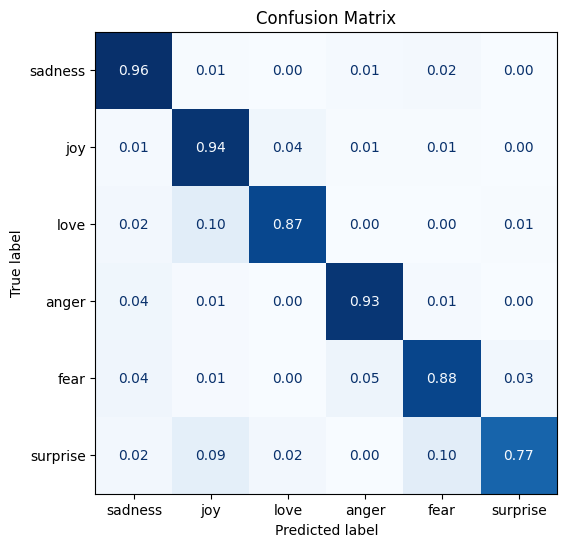

In [53]:
labels = emotions["train"].features["label"].names
y_valid = np.array(emotions["validation"]["label"])
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

In [55]:
# Share model with others
trainer.push_to_hub(commit_message="Training completed!")

Upload file pytorch_model.bin:   0%|          | 1.00/255M [00:00<?, ?B/s]

Upload file runs/Apr24_22-01-44_Desktop-Matthias/events.out.tfevents.1682366646.Desktop-Matthias.23196.0:   0%…

KeyboardInterrupt: 

In [ ]:
## TODO: Improve model card

## Test the model

In [56]:
# Load model and create classifier pipeline
from transformers import pipeline
model_id = "Promotos/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

c:\Python310\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


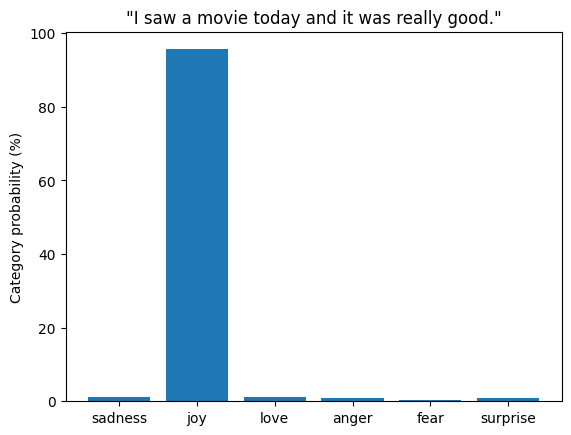

In [62]:
# Execute prediction
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

# Visualize result
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Category probability (%)")
plt.show()